In [0]:
# import libraries
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms

In [0]:
# number of subprocesses to use for data loading
num_workers = 0

# how many samples per batch to load
batch_size=64

# convert data to float tensor
transform = transforms.ToTensor()

# get the training data
train_data = datasets.MNIST(root='data', train=True, transform=transform, 
                            download=True)

# prepare the dataloader
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, 
                                           batch_size=batch_size, 
                                           num_workers=num_workers)

In [3]:
len(train_loader.dataset)

60000

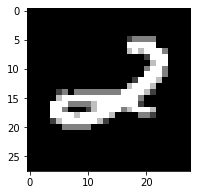

In [4]:
# visualize the data
dataiter = iter(train_loader)
images, labels = next(dataiter)

images = images.numpy()

# get one image from the batch
image = images[0].squeeze()

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.imshow(image, cmap='gray')
plt.show()

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):

        super(Discriminator, self).__init__()

        #  define all layers
        self.fc1 = nn.Linear(input_size, hidden_dim[0])
        self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.fc3 = nn.Linear(hidden_dim[1], hidden_dim[2])
        self.fc4 = nn.Linear(hidden_dim[2], output_size)
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        # do the forward pass
        x = x.view(-1, 28*28)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        x = self.fc4(x)

        return x

In [0]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):

        super(Generator, self).__init__()

        # define all layers
        self.fc1 = nn.Linear(input_size, hidden_dim[0])
        self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.fc3 = nn.Linear(hidden_dim[1], hidden_dim[2])
        self.fc4 = nn.Linear(hidden_dim[2], output_size)
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        # do the forward pass
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        x = torch.tanh(self.fc4(x))

        return x


# Model Hyperparameters

In [0]:
# Discriminator hyperparams

# Size of the input image to discriminator (28*28)
input_size = 28*28

# Size of the discriminator output (real or fake)
d_output_size = 1

# Size of hidden layer of the discriminator
d_hidden_size = [256, 128, 64]

# Generator hyperparams

# Size of the latent vector to give to generator
z_size = 32

# Size of the generator output (generated image)
g_output_size = 28*28

# Size of the hidden layer of the generator
g_hidden_size = [64, 128, 256]

# Build complete network

Instantiate discriminator and generator.

In [8]:
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check them as we expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

Generator(
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=784, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [0]:
from IPython.display import Image

# Calculate Losses

Now we need to calculate the losses. 

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

<!-- <img src='gan_pipeline.png' width=70% /> -->



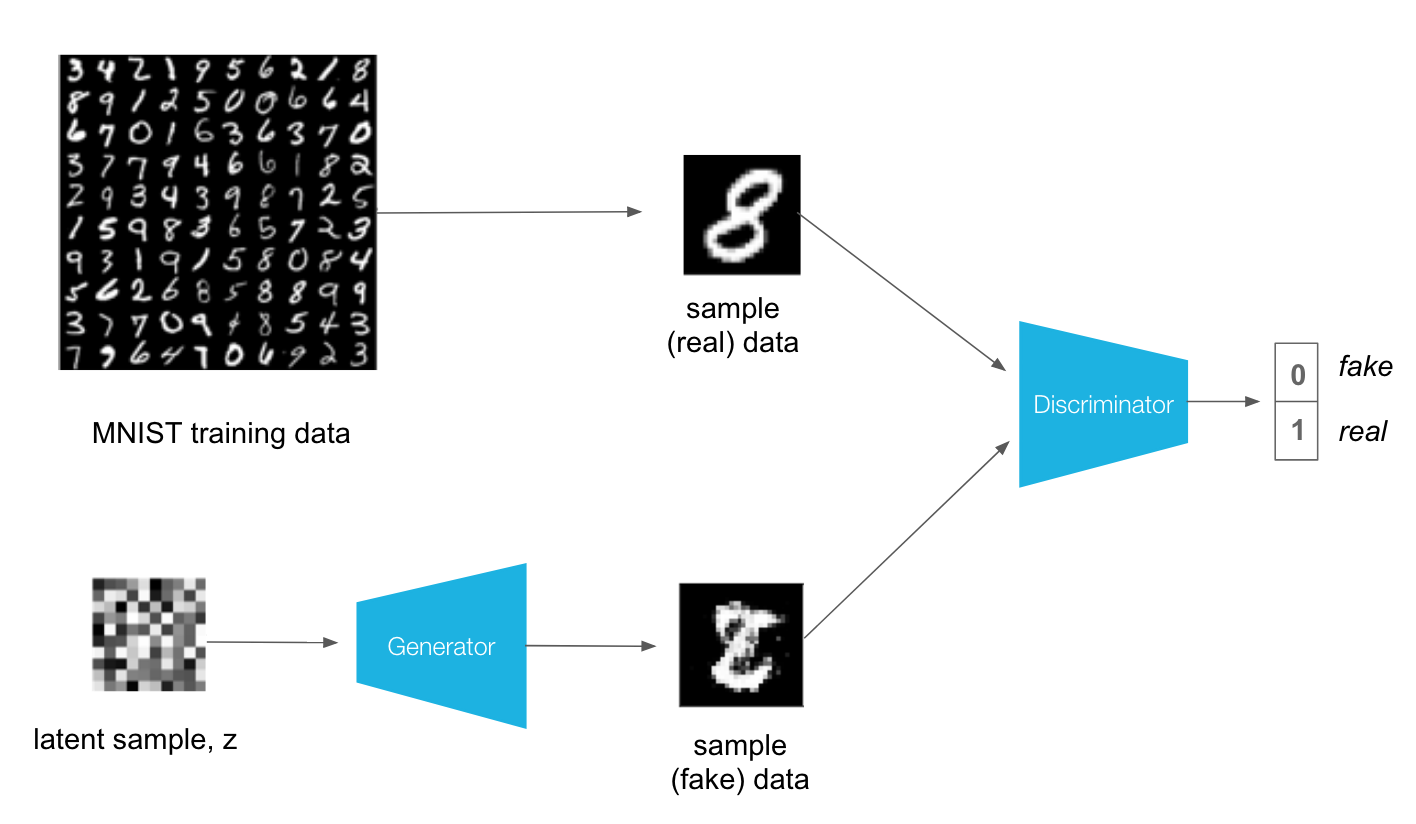

In [10]:
Image('gan_pipeline.png')

The losses will be binary cross entropy loss with logits, which we can get with [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss). This combines a `sigmoid` activation function **and** and binary cross entropy loss in one function.

For the real images, we want `D(real_images) = 1`. That is, we want the discriminator to classify the the real images with a label = 1, indicating that these are real. To help the discriminator generalize better, the labels are **reduced a bit from 1.0 to 0.9**. For this, we'll use the parameter `smooth`; if True, then we should smooth our labels. In PyTorch, this looks like `labels = torch.ones(size) * 0.9`

The discriminator loss for the fake data is similar. We want `D(fake_images) = 0`, where the fake images are the _generator output_, `fake_images = G(z)`. 

### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get `D(fake_images) = 1`. In this case, the labels are **flipped** to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real!

In [0]:
def real_loss(D_out, smooth=False):
    # compare logits to real labels
    # smoothen labels if smooth=True
    if smooth:
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)

    return loss

def fake_loss(D_out):
    # compare logits to fake labels
    batch_size = D_out.size(0)

    labels = torch.zeros(batch_size)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)

    return loss

# Optimizers

In [0]:
import torch.optim as optim

# learning rate
dlr = 0.003
glr = 0.001
# Create optimizers for discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr=dlr)
g_optimizer = optim.Adam(G.parameters(), lr=glr)

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses in all of the following cases.

### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

#### Saving Samples

As we train, we'll also print out some loss statistics and save some generated "fake" samples.

In [13]:
import pickle as pkl 

# training hyperparams
num_epochs = 50

# keep track of losses
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size = 16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()

for epoch in range(num_epochs):

    for batch_i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)

        # Important rescaling step
        real_images = real_images*2 - 1

        # =====================================================
        #               TRAIN THE DISCRIMINATOR
        # =====================================================

        # Train with real images
        d_optimizer.zero_grad()
        d_output = D(real_images)
        d_real_loss = real_loss(d_output, smooth=True)

        # Train with fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)

        # Compute the discriminator loss on fake images
        d_fake = D(fake_images)
        d_fake_loss = fake_loss(d_fake)
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        # ======================================================
        #               TRAIN THE GENERATOR
        # ======================================================

        g_optimizer.zero_grad()

        # Generate fake images --> WHY DO I NEED TO GENERATE THESE AGAIN?
        # z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        # z = torch.from_numpy(z).float()
        fake_images = G(z)

        # Compute the generator loss on fake images
        g_output = D(fake_images)
        g_loss = real_loss(g_output)

        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator losses
            print(f"Epoch [{(epoch+1):2d} / {(num_epochs):2d}] | d_loss: {(d_loss.item()):6.4f} | g_loss: {(g_loss.item()):6.4f}")

    # After each epoch
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))

    # generate and save sample, fake images
    G.eval()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train()  # back to train mode

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [ 1 / 50] | d_loss: 1.3836 | g_loss: 0.7111
Epoch [ 1 / 50] | d_loss: 1.0270 | g_loss: 1.5449
Epoch [ 1 / 50] | d_loss: 0.6451 | g_loss: 5.9665
Epoch [ 2 / 50] | d_loss: 1.2961 | g_loss: 1.0025
Epoch [ 2 / 50] | d_loss: 1.0523 | g_loss: 1.1305
Epoch [ 2 / 50] | d_loss: 0.7583 | g_loss: 3.2951
Epoch [ 3 / 50] | d_loss: 0.7374 | g_loss: 2.6792
Epoch [ 3 / 50] | d_loss: 0.9451 | g_loss: 2.8015
Epoch [ 3 / 50] | d_loss: 0.5620 | g_loss: 6.2871
Epoch [ 4 / 50] | d_loss: 0.7802 | g_loss: 2.8506
Epoch [ 4 / 50] | d_loss: 0.8739 | g_loss: 3.0994
Epoch [ 4 / 50] | d_loss: 1.0274 | g_loss: 2.5792
Epoch [ 5 / 50] | d_loss: 0.9792 | g_loss: 2.5615
Epoch [ 5 / 50] | d_loss: 0.9417 | g_loss: 2.0442
Epoch [ 5 / 50] | d_loss: 0.7542 | g_loss: 3.0632
Epoch [ 6 / 50] | d_loss: 0.7349 | g_loss: 3.6018
Epoch [ 6 / 50] | d_loss: 0.9683 | g_loss: 2.5258
Epoch [ 6 / 50] | d_loss: 0.9055 | g_loss: 2.3718
Epoch [ 7 / 50] | d_loss: 0.7700 | g_loss: 2.9652
Epoch [ 7 / 50] | d_loss: 0.7497 | g_loss: 3.3197


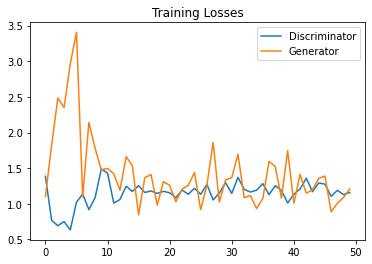

In [14]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

## Generate samples from training

In [0]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [0]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

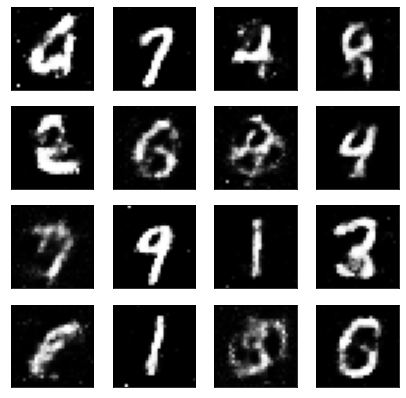

In [17]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

In [29]:
len(samples), len(samples[::int(len(samples)/10)])

(50, 10)

Below I'm showing the generated images as the network was training, every 10 epochs.

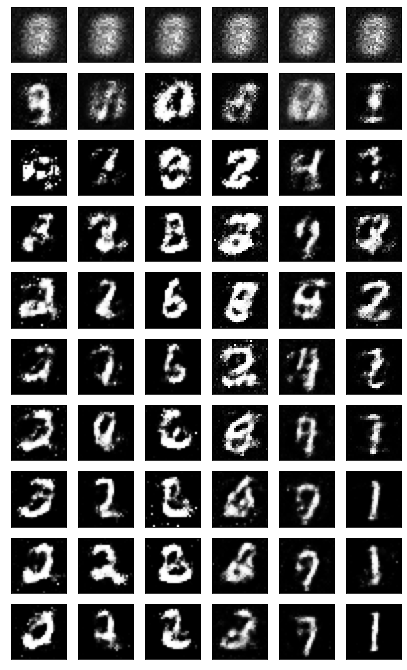

In [30]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

## Sampling from the generator

We can also get completely new images from the generator by using the checkpoint we saved after training. **We just need to pass in a new latent vector $z$ and we'll get new samples**!

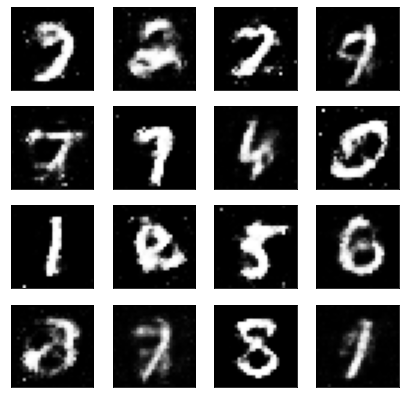

In [19]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])